In [1]:
import json, base64, uuid, time, subprocess, re, os, tempfile
from pathlib import Path
from typing import List, Any

from google import genai
from google.genai import types
from google.genai.types import CreateBatchJobConfig, JobState, Part
from google.cloud import storage
from concurrent.futures import ThreadPoolExecutor, as_completed

# ---------------------------------------------------------------------
# ⚙️  ENV
# ---------------------------------------------------------------------
!export GOOGLE_CLOUD_LOCATION=us-central1
!export GOOGLE_GENAI_USE_VERTEXAI=True
!export GOOGLE_CLOUD_PROJECT=gen-lang-client-0902395469

client = genai.Client(location="us-central1",
                      project="gen-lang-client-0902395469",
                      vertexai=True)

# ---------------------------------------------------------------------
# 🎞️  video utilities
# ---------------------------------------------------------------------
MIN_DURATION = 1.4         # seconds – pad anything shorter
def get_duration_sec(local_path: str) -> float:
    """Return video duration in seconds (ffprobe required)."""
    try:
        out = subprocess.check_output(
            ["ffprobe", "-v", "error",
             "-show_entries", "format=duration",
             "-of", "default=noprint_wrappers=1:nokey=1",
             local_path],
            text=True)
        return float(out.strip())
    except Exception:
        return 0.0    # treat errors as 0-length
    

def pad_short_clip(input_path: str, duration: float = 5.0) -> str:
    """
    Pads |input_path| to at least |duration| seconds, returns a *fresh*
    temp-file path.  The -y flag forces ffmpeg to overwrite silently.
    """
    # always create a brand-new temp name
    fd, tmp_out = tempfile.mkstemp(suffix=".mp4")
    os.close(fd)                 # close the empty file handle
    os.unlink(tmp_out)           # remove it so ffmpeg sees no pre-existing file

    subprocess.run([
        "ffmpeg", "-y",          # <-- makes ffmpeg overwrite without asking
        "-loglevel", "error",
        "-stream_loop", "-1",
        "-i", input_path,
        "-t", str(duration),
        "-c:v", "libx264",
        "-preset", "veryfast",
        "-crf", "23",
        "-c:a", "aac", "-ac", "2", 
        tmp_out
    ], check=True)

    return tmp_out


def _maybe_pad_local(local_path: str) -> str:
    dur = get_duration_sec(local_path)
    if dur < MIN_DURATION:
        print(f"[pad] {Path(local_path).name} is {dur:.2f}s – padding …")
        return pad_short_clip(local_path, duration=max(MIN_DURATION * 1.5, 1.5))
    return local_path

# ---------------------------------------------------------------------
# ☁️  GCS helper
# ---------------------------------------------------------------------
def upload_video_if_needed(local_path: str,
                           bucket_name: str = "batched",
                           prefix: str = "videos/") -> str:
    """
    • Pads clips shorter than MIN_DURATION before upload
    • Uploads to gs://<bucket>/<prefix>/<filename> if not present
    • Returns the gs:// URI
    """
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)

    # ① pad if necessary

    blob_name = f"{prefix}{Path(local_path).name}"
    blob = bucket.blob(blob_name)
    if not blob.exists():
        blob.upload_from_filename(_maybe_pad_local(local_path))
    return f"gs://{bucket_name}/{blob_name}"

# ---------------------------------------------------------------------
# 🔻  single request (inline data)
# ---------------------------------------------------------------------
def single_llm_request(prompt: str, video_file: str) -> str:
    video_file = _maybe_pad_local(video_file)      # ensure ≥ 1 s
    with open(video_file, "rb") as f:
        video_bytes = base64.b64encode(f.read()).decode("utf-8")

    response = client.models.generate_content(
        model="models/gemini-2.5-pro-preview-03-25",
        contents=types.Content(
            parts=[
                Part(inline_data=types.Blob(data=video_bytes,
                                            mime_type="video/mp4")),
                Part(text=prompt)
            ]))

    # clean up temp file if we padded
    if video_file != video_file and video_file.startswith(tempfile.gettempdir()):
        os.unlink(video_file)

    return response.candidates[0].content.parts[0].text

# ---------------------------------------------------------------------
# 🔻  multi-thread helper (unchanged)
# ---------------------------------------------------------------------
def multiple_llm_request(video_files: List[str], prompts: List[str],
                         max_workers: int = 100) -> List[Any]:
    results: List[Any] = [None] * len(video_files)

    def _worker(idx: int, pr: str, path: str):
        results[idx] = single_llm_request(pr, path)

    with ThreadPoolExecutor(max_workers=max_workers) as pool:
        futs = [pool.submit(_worker, i, prompts[i], vf)
                for i, vf in enumerate(video_files)]
        for fut in as_completed(futs):
            try:
                fut.result()
            except Exception as exc:
                idx = futs.index(fut)
                print(f"[error] {video_files[idx]} → {exc}")
                results[idx] = exc
    return results

# ---------------------------------------------------------------------
# 🔻  batch helpers (only upload_video_if_needed changed)
# ---------------------------------------------------------------------
import concurrent.futures

def create_and_upload_batch_request(video_paths, prompts):
    storage_client = storage.Client()
    bucket = storage_client.bucket("batched")
    batch_id = str(uuid.uuid4())
    blob = bucket.blob(f"batch_{batch_id}.jsonl")

    # Helper function to upload a single video and prepare the JSON line
    def process_video(idx_vp):
        idx, vp = idx_vp
        gcs_uri = upload_video_if_needed(vp)  # padded if needed
        return json.dumps({
            "request": {
                "contents": [{
                    "role": "user",
                    "parts": [
                        {"file_data": {"file_uri": gcs_uri, "mimeType": "video/mp4"}},
                        {"text": prompts[idx]}
                    ]
                }]
            },
            "index": str(idx)
        })

    with blob.open("w") as fh:
        with concurrent.futures.ThreadPoolExecutor(max_workers=100) as executor:
            # Map over indexed video_paths
            futures = executor.map(process_video, enumerate(video_paths))
            for jsonl_line in futures:
                fh.write(jsonl_line + "\n")

    return f"gs://batched/batch_{batch_id}.jsonl"

def await_batch_results(cloud_url: str) -> List[dict]:
    storage_client = storage.Client()
    batch_id = str(uuid.uuid4())
    output_uri = f"gs://batched/batch_{batch_id}_output"

    job = client.batches.create(
        model="gemini-2.0-flash-001",
        src=cloud_url,
        config=CreateBatchJobConfig(dest=output_uri),
    )

    completed = {JobState.JOB_STATE_SUCCEEDED,
                 JobState.JOB_STATE_FAILED,
                 JobState.JOB_STATE_CANCELLED,
                 JobState.JOB_STATE_PAUSED}

    while job.state not in completed:
        time.sleep(30)
        job = client.batches.get(name=job.name)

    prediction_blob = next(
        b for b in storage_client.bucket("batched")
                                .list_blobs(prefix=f"batch_{batch_id}_output/")
        if b.name.endswith("/predictions.jsonl"))

    parsed_by_idx = {}
    with prediction_blob.open("r") as fh:
        for line in fh:
            if not line.strip():
                continue
            data = json.loads(line)
            idx = int(data.get("index", -1))
            txt = "error"
            if "candidates" in data['response'].keys():
                try:
                    txt = data["response"]["candidates"][0]["content"]["parts"][0]["text"]
                except Exception as e:
                    print(f"[error] {e}")
                    
            parsed_by_idx[idx] = extract_json(txt)

    return [parsed_by_idx[i] for i in sorted(parsed_by_idx)]

def extract_json(response_text):
    # Regex to extract JSON between curly braces
    json_match = re.search(r'\{.*\}', response_text, re.DOTALL)
    if json_match:
        json_text = json_match.group()
        try:
            return json.loads(json_text)
        except Exception as e:
            return json_text  # Return the raw text if JSON parsing fails
    else:
        return response_text
        
def invoke_batch(video_paths: List[str], prompts: List[str]) -> List[dict]:
    cloud_url = create_and_upload_batch_request(video_paths, prompts)
    return await_batch_results(cloud_url)


In [2]:
import os

def get_relative_paths(root_dir):
    relative_paths = []
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for file in filenames:
            full_path = os.path.join(dirpath, file)
            relative_path = os.path.relpath(full_path, root_dir)
            relative_paths.append(os.path.join(root_dir,relative_path))
    return relative_paths

# Directory path
directory = "/Users/christopheroosthuizen/project/tester/MELD/MELD.Raw/train/train_splits"

# Get relative paths
relative_paths = get_relative_paths(directory)

PROMPT = """
You are a emotional conversation analysis model. 
Given A video clip I want you to describe you're belives emotions and sentiment. 
I want you to describe the body language and transcribe the dialog the person speaks. I want you to also enphasize if they enpathized any parts of speech.
Output the result in JSON format.
The JSON should contain the following fields:
- dialog: the transcribed dialog
- body_language: the body language of the person
- emotions: a list of emotions expressed in the video
- sentiment: the overall sentiment of the video
- empathy: a list of parts of speech that were emphasized
- volume: the volume of the person speaking, weather it was loud or soft or normal
- inflection: describe the inflection of the person
- speech_rate: the rate of speech of the person
- gestures: any gestures made by the person
- eye_contact: whether the person appears to be making eye contact
- facial_expressions: the facial expressions of the person
- posture: the posture of the person
- person description: a description of the person in the video
- energy: of the speech
Here is an example of the JSON format:
{
  "dialog": "I can't believe you did that!",
  "body_language": "arms crossed, frowning",
  "emotions": ["anger", "disgust"],
  "sentiment": "negative",
  "empathy": ["can't", "believe"],
  "volume": "loud",
  "inflection": "high-pitched",
    "speech_rate": "fast and hurried",
    "gestures": ["pointing", "shaking head"],
    "eye_contact": "direct eye contact",
    "facial_expressions": ["furrowed brow", "tight lips"],
    "posture": "leaning forward, closed off,tense",
    "person_description": "white women with brown hair and blue eyes wearing  a fancy red dress",
    "energy": "very high",
}"""



In [ ]:
import pandas as pd
import numpy as np

data = pd.read_csv("/Users/christopheroosthuizen/project/tester/MELD/preprocessed_test.csv")
import pandas as pd

# Extract numeric values from 'video_file'
data['dialog_num'] = data['video_file'].str.extract(r'dia(\d+)_utt')[0].astype(int)
data['utt_num'] = data['video_file'].str.extract(r'utt(\d+)')[0].astype(int)

# Sort by extracted numbers
data = data.sort_values(by=['dialog_num', 'utt_num']).reset_index(drop=True)

# Drop helper columns if no longer needed
data = data.drop(columns=['dialog_num', 'utt_num'])

data.drop_duplicates(subset=['video_file'], inplace=True)
# Display result
data = data
data.head()

In [4]:
prompts = []
base_prompt ="""You are an emotional conversation analysis model. You will be given a video clip a transcript of the video clip and a series of emotional scene graphs leading up to your current scene.
            Using this information you will be asked to predict the exact emotions of the current dialogue. The sentiment and if the character is being sarcastic or not. The last scene graph you will be given is the current scene. But this scene graph was generated without any of the previous context. 
            While you will be given a full transcript of the video clip you will also be given a utterance of the current scene. This is the text you should focus solely on. Any other text in the current scene is likly background noise.
            Remember you are anylizing the freinds tv show, so you can use the context of the show to help you determine the emotions. Actors are often over the top and the show is a comedy. 
            So disagreeing with its emotional analysis is expected. Remember that neutral is most often the correct answer. Remember you are trying to determine the emotions of the current person in the video clip. 
            Remember that each individual scene graph, was made without the context of the other scene graphs. This makes a individual scene graph not very useful and could be wrong about previous scenes emotional state. 
            Attempt to remedy this by using all the scene graphs as a whole to determine the emotions of the current scene.
            You will output the result in JSON format. The JSON should contain the following fields:
            - emotion: the emotions you can pick from are 
0 → anger
  • Visual / Body
      – Lowered, knit brows; glaring eyes; jaw clench; forward lean.
  • Speech / Prosody & Wording
      – Raised volume, clipped articulation, harsher or sharper consonants.
      – Frequent “you”-directed phrases, e.g. “You never…”, “Why don’t you…”
      – Fewer hedges, more imperatives.
      - because this is a comedy show, anger is often used in a joking manner.
      - usually this emotion comes out when another character has done something wrong or annoying.

1 → disgust
  • Visual / Body
      – Wrinkled nose, upper-lip raise; torso or head tilts away.
  • Speech / Prosody & Wording
      – Breathy exhalations (“ugh”, “ew”), nasal constriction.
      – Words of revulsion: “gross”, “nasty”, “can’t stand”.
      – Short, dismissive sentences; falling final intonation.

2 → fear
  • Visual / Body
      – Widened eyes, raised inner brows; shoulders lift; protective gestures.
  • Speech / Prosody & Wording
      – Higher-than-baseline pitch, shaky or tremulous voice, faster tempo.
      – Uncertainty markers: “I-I don’t know”, “maybe”, “could”, "No don't!".
      – Involuntary gasps, audible swallow.
      - Usually when the character is responding to something unexpected or scary.
      - Similar to suprised but the character distincly does not want something to happen.


3 → joy
  • Visual / Body
      – Duchenne smile (cheek raise + eye crinkle); relaxed, open posture.
  • Speech / Prosody & Wording
      – Melodic intonation, steady or rising pitch slope, laughs or chuckles.
      – Positive lexicon: “great!”, “awesome”, “so happy”.
      – Expanded vowel length (“sooo good”), playful interjections.
      - second most common emotion in the dataset. Use with care as its often paired with something the character is happy about.
      - this is often paired with a loudness increase. a simple smile in a professional setting is not joy.
      - this is often paired with a reason for why the character is happy.

4 → neutral
  • Visual / Body
      – Resting face, minimal gesturing; balanced posture.
  • Speech / Prosody & Wording
      – Even volume, mid-range pitch, steady tempo.
      – Factual wording without evaluative adjectives.
      – Few discourse markers; pauses only for breath.
      - sometimes mistaken for joy, but lacks the same level of expressiveness.
      - the character may be smiling or laughing, but it is not as pronounced as in joy.
      - this is especially common when the character is trying to hide their true emotions.
      - usually loudness is a good indicator the text is not neutral.
      - consider the person and the context of the scene. If the character is responding to something sad or negative then its likely sadness.


5 → sadness
  • Visual / Body
      – Inner brow raise, lip corners down; slumped or inward-turned shoulders.
  • Speech / Prosody & Wording
      – Lower pitch, reduced volume, slower pace; frequent sighs.
      – Lexical markers: “sorry”, “I miss…”, “wish it were…”.
      – Descending intonation at phrase ends; elongated syllables.
      - Can be mistaken for anger. But if the character is responding to something sad or negative then its likely sadness.
      - This can be further clarified if the character appears to be taking a more passive role, dropping a topic or not engaging with the other character.
      - This should be paired with a reason for why the character is sad.

6 → surprise
  • Visual / Body
      – Brows lift, eyes widen, mouth opens; rapid head jerk or recoil.
  • Speech / Prosody & Wording
      – Sharp inhalation or “oh!”, “whoa!”, initial rise-fall pitch contour.
      – Rapid onset, then quick return to baseline unless emotion shifts.
      – If joy indicators follow (laughter, upbeat tone), label as *surprise*.
      - very common in the dataset. Assume its suprise over even nuetral if the character is responding to something unexpected.


            - sentiment: the overall sentiment of the video you can pick from: 
negative -> 0 
neutral -> 1
positive -> 2
            - sarcasm: whether the person is being sarcastic or not you can pick from: true -> 1
false -> 0

            Here is an example of the JSON format:
            {
              "emotional_explanation": "The character seems to have been threatened by the other character, which is why they are angry., this is shown by his loud tone and his aggressive body language.",
              "emotion": 0,
              "sentiment_explanation": "The character seems to be angry which indicates a negative body tone, this is shown by his loud tone and his aggressive body language.",
              "sentiment": 0,
              "sarcasm_explanation": "There is no indication of sarcasm in the character's tone or body language.",
              "sarcasm": 1
            }
            Scene graphs:
            """

In [5]:
scene_graph_combination_prompt = """
SYSTEM
You are **SceneGraph-GPT**, a specialist at distilling multiple emotional
scene-graphs from a single conversation into one concise summary.

TASK
1. Read *all* provided scene-graphs (they are in chronological order).
2. Infer the key conversational context and the emotional trajectory of
   each character.
3. Identify any clear turning-point (an event that flips tone, topic, or
   emotion).
4. Try to summarize what they are talking about. 
5. Summarize what the intentions of the characters are.
6. Summarize the emotional state of the characters.
7. Summarize the emotional state of the scene.
8. Summerize the body language of the characters.
9. Summerize what the characters are doing.
10. Summerize the setting of the scene.
"""

In [6]:
local_scene_graph_combination_prompt = """
You are a emotional conversation analysis model. You will be given a video clip a transcript of the video clip and a series of emotional scene graphs leading up to your current scene.
You will be given 4 scene graphs. The first two scene graphs are the previous two scenes. The last two scene graphs are the current scene and the scene after it.
Using this information you are meant to summerize and predict the emotions of the current dialogue. What they might be feeling and what they might be saying.
You will also be given a whole scene summary of the video clip. 
Example:
{
  "summary": "Rachel confronts Ross about hiding a letter; the discussion turns playful.",
  "characters": ["Rachel", "Ross"],
  "emotional_states": ["anger", "surprise"],
  "expression": "Rachel's raised voice, crossed arms, and accusatory wording signal anger; Ross's widened eyes and defensive posture indicate surprise.",
  "body_language": "Rachel's arms are crossed and she is frowning, while Ross has widened eyes and a defensive posture.",
  "context": "Earlier, Ross secretly read a personal letter addressed to Rachel.",
  "body_language": "Rachel's arms are crossed and she is frowning, while Ross has widened eyes and a defensive posture.",
  "turning_point": "Ross admits he opened the letter, shifting Rachel from calm to angry.",
  "important_information": "Letter contents reveal Ross's lingering feelings, setting up a future subplot.",
  "emotional_summary": "Tension peaks but ends on a light, teasing note.",
  "text exchange": "Rachel: I can't believe you did that! Ross: I didn't mean to! Rachel: You always do this! Ross: I'm sorry, I just wanted to know what it said.",
  "emotional_explanation": "Rachel's raised voice, crossed arms, and accusatory wording signal anger; Ross's widened eyes and defensive posture indicate surprise."
}
"""

In [7]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
)


def extract_json(response_text):
    # Regex to extract JSON between curly braces
    json_match = re.search(r'\{.*\}', response_text, re.DOTALL)
    if json_match:
        json_text = json_match.group()
        try:
            return json.loads(json_text)
        except Exception as e:
            return json_text  # Return the raw text if JSON parsing fails
    else:
        return response_text
# ----------------------------------------------------------
# 1. SINGLE-SCENE GRAPH GENERATION
# ----------------------------------------------------------
def create_single_frame_graphs(
    df: pd.DataFrame,
    root_dir: str,
    prompt_template: str,
    invoke_batch_fn,
    video_col: str = "video_file",
    out_col: str = "scene_graph",
) -> pd.DataFrame:
    """
    For every row in *df*, call the multimodal model once and store the raw
    per-scene graph JSON in *out_col*.

    Parameters
    ----------
    df : DataFrame
        Must contain a column with relative video-file names.
    root_dir : str
        Folder that holds all video files.
    prompt_template : str
        Few-shot prompt shown to the model for every clip.
    invoke_batch_fn : Callable[[List[str], List[str]], List[dict]]
        Your own wrapper that accepts a list of *paths* and *prompts*
        (same length) and returns a list of JSON-serialisable objects.
    video_col, out_col : str
        Column names to read videos from / write results to.

    Returns
    -------
    DataFrame  (same object, modified in-place and returned for chaining)
    """
    # Absolute paths for the batch call
    file_paths = [os.path.join(root_dir, fn) for fn in df[video_col]]
    prompts = [prompt_template] * len(df)

    # Model inference
    raw_graphs = invoke_batch_fn(file_paths, prompts)

    # Persist
    df[out_col] = raw_graphs
    return df


# ----------------------------------------------------------
# 2. VERY-NAÏVE DIALOGUE-LEVEL UNDERSTANDING
# ----------------------------------------------------------
def naive_scene_graph_understanding(
    df: pd.DataFrame,
    base_prompt: str,
    invoke_batch_fn,
    root_dir: str,
    dialogue_id_col: str = "Dialogue_ID",
    utterance_col: str = "Utterance",
    graph_col: str = "scene_graph",
) -> pd.DataFrame:
    """
    Uses the running list of previous scene graphs in a dialogue as context
    and asks the model for emotion / sentiment / sarcasm for the *current* row.

    Adds three new integer columns:  *emotion*, *sentiment*, *sarcasm*.
    """

    # Build running-total strings for every dialogue
    running_total = ""
    current_dialogue = None
    history_per_row = []

    for idx, row in df.iterrows():
        dlg = row[dialogue_id_col]

        if dlg != current_dialogue:
            # New conversation → reset the accumulator
            current_dialogue = dlg
            running_total = ""
        try:
            # Append the current scene graph to the running total
            running_total += row[graph_col] + "\n"
        except:
            # Handle the case where the scene graph is not available
            running_total += str({"error": "Scene graph not available"}) + "\n"
        
        history_per_row.append(running_total.strip())

    # Compose prompts (one per row)
    prompts = []
    for hist, row in zip(history_per_row, df.itertuples()):
        prompt = (
            base_prompt
            + "\nScene graphs (full context):\n"
            + hist
            + "\n\nCurrent scene graph:\n"
            + str(getattr(row, graph_col))
            + "\nUtterance of scene: "
            + getattr(row, utterance_col)
            + "\n"
        )
        prompts.append(prompt)

    # Batch inference
    video_paths = [os.path.join(root_dir, fn) for fn in df["video_file"]]
    results = invoke_batch_fn(video_paths, prompts)
    for i, r in enumerate(results):
        
        results[i] = r  # JSON parsing# Default values

    # Explode the JSON into columns
    # Build each column in a single pass, falling back to the default values
    df["emotion"]   = [r.get("emotion",   4) if isinstance(r, dict) else 4 for r in results]
    df["sentiment"] = [r.get("sentiment", 1) if isinstance(r, dict) else 1 for r in results]
    df["sarcasm"]   = [r.get("sarcasm",   0) if isinstance(r, dict) else 0 for r in results]
    return df


# ----------------------------------------------------------
# 4. HIERARCHICAL PIPELINE ( global → local → final inference )
# ----------------------------------------------------------
from __future__ import annotations
import os, json, itertools
import pandas as pd
import os
import json
import base64
from typing import List, Optional, Union
from typing import Callable, List, Dict, Any

def hierarchical_emotion_pipeline(
    df: pd.DataFrame,
    root_dir: str,
    *,
    # ---- model-specific wrappers -----------------------------------------
    invoke_video_fn : Callable[[List[str], List[str]], List[Dict[str,Any]]],
    # ---- column names -----------------------------------------------------
    dialogue_id_col : str = "Dialogue_ID",
    utterance_col   : str = "Utterance",
    video_col       : str = "video_file",
    scene_graph_col : str = "scene_graph",
    # ---- prompt templates -------------------------------------------------
    global_prompt_template : str = scene_graph_combination_prompt,
    local_prompt_template  : str = local_scene_graph_combination_prompt,
    base_prompt_template   : str = base_prompt,
) -> pd.DataFrame:
    """
    Three-stage hierarchy                                    (see ascii art)
              ┌─────────────┐   ┌─────────────┐
    graphs →  │  GLOBAL SG  │→→ │  LOCAL SG   │→→ final emotion / sentiment / sarcasm
              └─────────────┘   └─────────────┘
    
    Parameters
    ----------
    df               : MELD-style dataframe (one row == one clip / utterance)
                       must already contain *scene_graph_col* (stage 0)
    root_dir         : path that, joined with *video_col*, yields MP4 locations
    invoke_video_fn  : (paths, prompts) -> list[ json ]
                       used once per row to get the FINAL prediction
    invoke_text_fn   : (prompts)       -> list[ json ]
                       pure text-only calls (global & local summaries)
    Returns
    -------
    The same dataframe, augmented with
        * global_summary
        * local_summary
        * emotion, sentiment, sarcasm          (ints)
    """
    # ------------------------------------------------------------------
    # A. GLOBAL  SUMMARIES  ( 1-per-dialogue )
    # ------------------------------------------------------------------
    global_summary_per_dialogue : Dict[int,str] = {}
    prompts_global : List[str]  = []
    dialogue_lookup : List[int] = []          # keeps order for mapping back

    for dlg_id, group in df.groupby(dialogue_id_col):
        all_graphs = "\n".join(str(g) for g in group[scene_graph_col])
        prompts_global.append(global_prompt_template + all_graphs)
        dialogue_lookup.append(dlg_id)

    # batch call (text-only)
    global_results = invoke_video_fn([None]*len(prompts_global),prompts_global)

    # store in dict  dlg_id → JSON-string
    for dlg_id, js in zip(dialogue_lookup, global_results):
        global_summary_per_dialogue[dlg_id] = str(js)

    # helper to fetch safely
    def get_global(dlg_id:int) -> str:
        return global_summary_per_dialogue[dlg_id]

    # ------------------------------------------------------------------
    # B. LOCAL  SUMMARIES  ( sliding window size 4 per row )
    # ------------------------------------------------------------------
    local_summaries : List[str] = []

    # build fast access arrays
    graphs_by_row  = df[scene_graph_col].tolist()
    dlg_ids_by_row = df[dialogue_id_col].tolist()

    for idx in range(len(df)):
        dlg = dlg_ids_by_row[idx]
        # indices of rows in the SAME dialogue
        dlg_indices = [i for i,j in enumerate(dlg_ids_by_row) if j == dlg]

        pos_in_dlg  = dlg_indices.index(idx)
        # pick previous-2, current, next-1 (pad with same graph if missing)
        window_ids  = [
            dlg_indices[max(pos_in_dlg-2,0)],
            dlg_indices[max(pos_in_dlg-1,0)],
            idx,
            dlg_indices[min(pos_in_dlg+1, len(dlg_indices)-1)]
        ]

        four_graphs = "\n".join(str(graphs_by_row[i]) for i in window_ids)

        prompt_local = (
            local_prompt_template +
            "\nWhole scene summary:\n" + get_global(dlg) +          # ← global
            "\nFour scene graphs (prev-2,current,next-1):\n" + four_graphs
        )
        local_summaries.append(prompt_local)

    # batch → JSON objects
    local_results     = invoke_video_fn([None]*len(local_summaries),local_summaries)
    local_json_strings= [str(js) for js in local_results]
    df["local_summary"] = local_json_strings            # keep full JSON if needed

    # ------------------------------------------------------------------
    # C. FINAL  INFERENCE  (video + local summary )
    # ------------------------------------------------------------------
    final_prompts : List[str] = []
    video_paths   : List[str] = [os.path.join(root_dir, fn) for fn in df[video_col]]

    for row, loc_sum in zip(df.itertuples(), local_json_strings):
        prompt = (
            base_prompt_template +
            "\nLocal scene summary:\n" + loc_sum +
            "\nScene graph:\n"       + str(getattr(row, scene_graph_col)) +
            "\nUtterance:\n"         + getattr(row, utterance_col) + "\n"
        )
        final_prompts.append(prompt)

    results = invoke_video_fn(video_paths, final_prompts)

    # explode predictions
# Build each column in a single pass, falling back to the default values
    df["emotion"]   = [r.get("emotion",   4) if isinstance(r, dict) else 4 for r in results]
    df["sentiment"] = [r.get("sentiment", 1) if isinstance(r, dict) else 1 for r in results]
    df["sarcasm"]   = [r.get("sarcasm",   0) if isinstance(r, dict) else 0 for r in results]

    # optional – keep global summary for inspection
    df["global_summary"] = [get_global(dlg) for dlg in dlg_ids_by_row]

    return df

# ----------------------------------------------------------
# 3. METRIC & CONFUSION-MATRIX DISPLAY
# ----------------------------------------------------------
def display_results(
    df: pd.DataFrame,
    label_cols=("emotion_label", "sentiment_label", "sarcasm_label"),
    pred_cols=("emotion", "sentiment", "sarcasm"),
):
    """
    Prints accuracy, classification report, and confusion matrix
    for each (prediction, label) pair.
    """
    for pred, true in zip(pred_cols, label_cols):
        title = pred.capitalize()
        acc = (df[pred] == df[true]).mean()
        print(f"\n=== {title} ===")
        print(f"Accuracy: {acc:.4f}\n")
        print(classification_report(df[true], df[pred]))

        cm = confusion_matrix(df[true], df[pred])
        ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap="Blues")
        plt.title(f"{title} – Confusion Matrix")
        plt.show()

    # Overall mean-accuracy (optional)
    avg_acc = sum((df[p] == df[t]).mean() for p, t in zip(pred_cols, label_cols)) / len(pred_cols)
    print(f"\nAverage accuracy of the three tasks: {avg_acc:.4f}")


# ----------------------------------------------------------
# EXAMPLE (wire everything together)
# ----------------------------------------------------------


[error] 'parts'

=== Emotion ===
Accuracy: 0.5123

              precision    recall  f1-score   support

           0       0.57      0.42      0.49       353
           1       0.20      0.12      0.15        98
           2       0.33      0.29      0.31       106
           3       0.48      0.58      0.53       529
           4       0.54      0.64      0.59       933
           5       0.54      0.31      0.39       193
           6       0.54      0.44      0.49       398

    accuracy                           0.51      2610
   macro avg       0.46      0.40      0.42      2610
weighted avg       0.51      0.51      0.50      2610



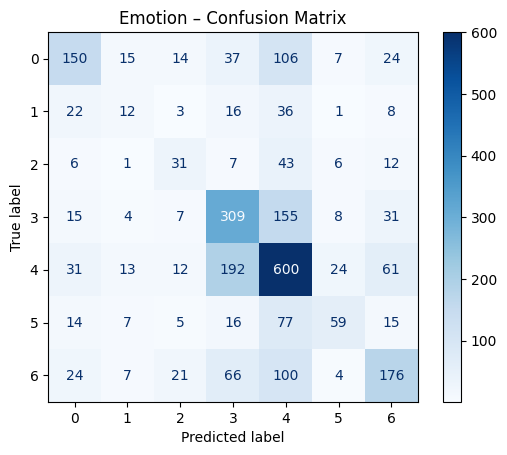


=== Sentiment ===
Accuracy: 0.5812

              precision    recall  f1-score   support

           0       0.76      0.50      0.61       947
           1       0.51      0.64      0.57       933
           2       0.55      0.62      0.58       730

    accuracy                           0.58      2610
   macro avg       0.61      0.58      0.58      2610
weighted avg       0.61      0.58      0.58      2610



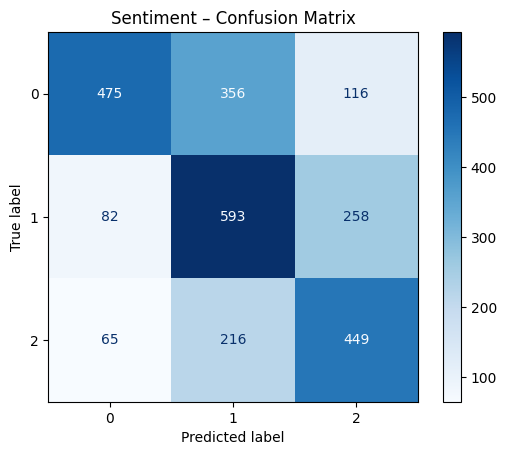


=== Sarcasm ===
Accuracy: 0.8958

              precision    recall  f1-score   support

           0       1.00      0.90      0.95      2610
           1       0.00      0.00      0.00         0

    accuracy                           0.90      2610
   macro avg       0.50      0.45      0.47      2610
weighted avg       1.00      0.90      0.95      2610



/opt/anaconda3/envs/tester/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/tester/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/tester/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


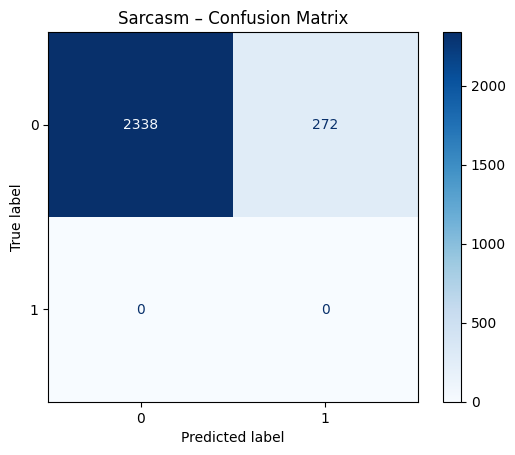


Average accuracy of the three tasks: 0.6631


In [8]:
# --- Load your dataframe here ---


ROOT = "/Users/christopheroosthuizen/project/tester/MELD/MELD.Raw/train/train_splits"

# --- 1) single-frame graphs ---

data = create_single_frame_graphs(data, ROOT, PROMPT, invoke_batch)

# --- 2) naïve dialogue-level inference ---
data = naive_scene_graph_understanding(data, base_prompt, invoke_batch, ROOT)

# --- 3) evaluation ---
display_results(data)

# 0) assume `df_raw` already has a column "scene_graph"
#    (if not, run create_single_frame_graphs first)

In [ ]:

df_predictions = hierarchical_emotion_pipeline(
    data,
    root_dir=ROOT,
    invoke_video_fn=multiple_llm_request,  
)

display_results(df_predictions)

[error] None → argument should be a str or an os.PathLike object where __fspath__ returns a str, not 'NoneType'
[error] None → argument should be a str or an os.PathLike object where __fspath__ returns a str, not 'NoneType'
[error] None → argument should be a str or an os.PathLike object where __fspath__ returns a str, not 'NoneType'
[error] None → argument should be a str or an os.PathLike object where __fspath__ returns a str, not 'NoneType'
[error] None → argument should be a str or an os.PathLike object where __fspath__ returns a str, not 'NoneType'
[error] None → argument should be a str or an os.PathLike object where __fspath__ returns a str, not 'NoneType'
[error] None → argument should be a str or an os.PathLike object where __fspath__ returns a str, not 'NoneType'
[error] None → argument should be a str or an os.PathLike object where __fspath__ returns a str, not 'NoneType'
[error] None → argument should be a str or an os.PathLike object where __fspath__ returns a str, not 'No

[out#0/mp4 @ 0x127e15cd0] Error opening output /var/folders/25/q16wk9s15v1dygtxrdhmpg6c0000gn/T/tmplijkvvk2.mp4: No space left on device
Error opening output file /var/folders/25/q16wk9s15v1dygtxrdhmpg6c0000gn/T/tmplijkvvk2.mp4.
Error opening output files: No space left on device
[out#0/mp4 @ 0x1345082d0] Error opening output /var/folders/25/q16wk9s15v1dygtxrdhmpg6c0000gn/T/tmpfmkmw7yf.mp4: No space left on device
Error opening output file /var/folders/25/q16wk9s15v1dygtxrdhmpg6c0000gn/T/tmpfmkmw7yf.mp4.
Error opening output files: No space left on device


[pad] dia127_utt1.mp4 is 1.00s – padding …
[pad] dia127_utt2.mp4 is 1.39s – padding …
[pad] dia128_utt0.mp4 is 1.04s – padding …
[pad] dia129_utt6.mp4 is 0.75s – padding …
[pad] dia129_utt8.mp4 is 1.00s – padding …
[pad] dia129_utt12.mp4 is 0.17s – padding …
[pad] dia129_utt13.mp4 is 0.75s – padding …
[pad] dia130_utt14.mp4 is 1.24s – padding …
[pad] dia130_utt16.mp4 is 0.79s – padding …
[pad] dia130_utt17.mp4 is 0.21s – padding …
[pad] dia135_utt1.mp4 is 0.77s – padding …[pad] dia132_utt9.mp4 is 0.71s – padding …
[pad] dia134_utt0.mp4 is 1.38s – padding …
[pad] dia135_utt4.mp4 is 1.38s – padding …

[pad] dia137_utt1.mp4 is 1.00s – padding …[pad] dia137_utt0.mp4 is 1.00s – padding …

[pad] dia136_utt2.mp4 is 0.63s – padding …
[pad] dia139_utt4.mp4 is 1.08s – padding …
[pad] dia144_utt4.mp4 is 0.54s – padding …
[pad] dia138_utt6.mp4 is 1.04s – padding …
[pad] dia146_utt8.mp4 is 0.75s – padding …
[pad] dia145_utt12.mp4 is 1.17s – padding …
[pad] dia145_utt3.mp4 is 1.17s – padding …
[pad]